Best Hyperparameters: {'max_depth': None, 'n_estimators': 200}

--- 3-Day Forecast Results ---

Date: 2025-03-24
Predicted Close: 118.31
Predicted Return: -0.19%
Recommended Action: Sell
Investment Amount: $0.00

Date: 2025-03-25
Predicted Close: 121.41
Predicted Return: 2.62%
Recommended Action: Buy
Investment Amount: $4,000.00

Date: 2025-03-26
Predicted Close: 123.13
Predicted Return: 1.42%
Recommended Action: Buy
Investment Amount: $4,000.00


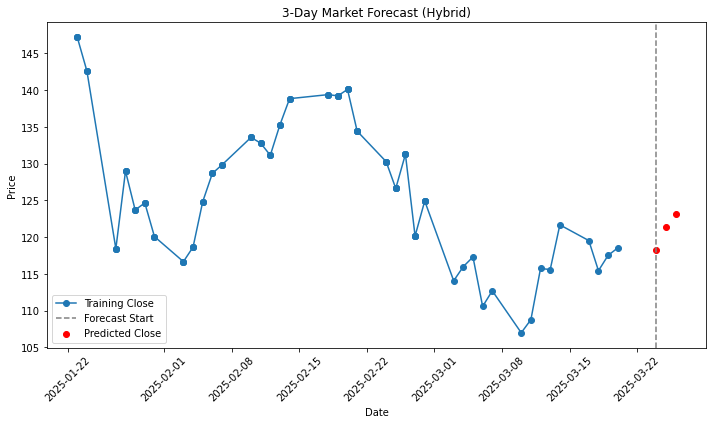

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.dates as mdates
from datetime import timedelta

#Loading our data here
df = pd.read_csv('Stock_Data.csv')
df['date'] = pd.to_datetime(df['date'])
df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

#Clean the data for whitespaces, commas, make sure they are the correct data type
columns = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in columns:
    df[col] = df[col].astype(str).str.replace('"', '').str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.dropna(subset=columns, inplace=True)

#Selection of advanced features here as well as calcualtion of relative strength index
df['movingavg'] = df['Close'].rolling(window=5).mean()
df['Return'] = df['Close'].pct_change()

def CalcRSI(series, window=7):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.rolling(window=window).mean()
    roll_down = down.rolling(window=window).mean()
    rs = roll_up / roll_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = CalcRSI(df['Close'], window=7)
df['Volatilty'] = df['Return'].rolling(window=3).std()
df['FirstLagC'] = df['Close'].shift(1)
df['SecLagC'] = df['Close'].shift(2)
df['FirstLagR'] = df['Return'].shift(1)
df['SecLagR'] = df['Return'].shift(2)
df['Target'] = df['Close'].shift(-1)
df.dropna(inplace=True)

# Select which day we want to simulate for and the next 2 business days after will automatically be added
simulatedate = pd.Timestamp('2025-03-24')

#Creating a rolling window for training data (set to 60 days due to volatile market changes in the last 2 months)
marketdays = 60
start_date = simulatedate - pd.Timedelta(days=marketdays)
train_subset = df[(df['date'] >= start_date) & (df['date'] < simulatedate)].copy()
if train_subset.empty:
    raise ValueError("Not enough training data available before the simulation date.")

#Define our features completely
features = ['Close', 'movingavg', 'Volume', 'Return', 'RSI', 'Volatilty',
            'FirstLagC', 'SecLagC', 'FirstLagR', 'SecLagR']

#Model is trained here
X_train = train_subset[features]
y_train = train_subset['Target']
#We use hyperparameter tuning along with timeseries split to tune our random forest model
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {'n_estimators': [100, 200], 'max_depth': [None, 5, 10]}
gridsearch = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
gridsearch.fit(X_train, y_train)
best_params = gridsearch.best_params_
print("Best Hyperparameters:", best_params)

model = RandomForestRegressor(**best_params, random_state=42)
model.fit(X_train, y_train)

#Here is where we predict the frist day accurately
final_row = train_subset.iloc[-1].copy()
test_input = pd.DataFrame([final_row[features]])
if test_input.isnull().any().any():
    test_input = test_input.fillna(method='ffill', axis=1).fillna(0)
predicted_close = model.predict(test_input)[0]
base_close = final_row['Close']
predicted_return = (predicted_close - base_close) / base_close

decision = "Buy" if predicted_return > 0.0015 else "Sell" if predicted_return < -0.001 else "Hold"

#This is our first day prediction using actual market data from the previous day to calculcate our decisions, the other days used the predicted close from day 1 to further forecast
future_preds = [{
    'date': simulatedate,
    'predicted_close': predicted_close,
    'predicted_return': predicted_return,
    'action': decision
}]

updated_row = final_row.copy()
updated_row['date'] = simulatedate
updated_row['Close'] = predicted_close
normaldataframe = pd.concat([train_subset, pd.DataFrame([updated_row])], ignore_index=True)

#We predict for the next 3 business days in order to make our decision, do we see a positive trend or a negative trend?
predictedays = 1  
current_date = simulatedate + timedelta(days=1)
while predictedays < 3:
    while current_date.weekday() >= 5 or current_date in df['date'].values:
        current_date += timedelta(days=1)

    last_row = normaldataframe.iloc[-1].copy()
    updated_row = last_row.copy()
    updated_row['date'] = current_date

    #We update the lag from market movements here
    updated_row['FirstLagC'] = last_row['Close']
    updated_row['SecLagC'] = last_row['FirstLagC']
    updated_row['FirstLagR'] = last_row['Return']
    updated_row['SecLagR'] = last_row['FirstLagR']
    updated_row['Return'] = (last_row['Close'] - last_row['FirstLagC']) / last_row['FirstLagC'] if last_row['FirstLagC'] != 0 else 0
    #We update our dataframe with the calcualted features
    closes = normaldataframe['Close'].tolist()[-4:] + [last_row['Close']]
    returns = normaldataframe['Return'].tolist()[-2:] + [updated_row['Return']]
    updated_row['movingavg'] = pd.Series(closes).mean()
    updated_row['Volatilty'] = pd.Series(returns).std()
    updated_row['RSI'] = CalcRSI(pd.Series(closes + [last_row['Close']])).iloc[-1]
    #Testing the dataframes here, we need to make sure the data is being added to the last row so that we get the most recent data for our forecasting
    test_input = pd.DataFrame([updated_row[features]])
    if test_input.isnull().any().any():
        test_input = test_input.fillna(method='ffill', axis=1).fillna(0)

    predicted_close = model.predict(test_input)[0]
    updated_row['Close'] = predicted_close
    normaldataframe = pd.concat([normaldataframe, pd.DataFrame([updated_row])], ignore_index=True)

    predicted_return = (predicted_close - last_row['Close']) / last_row['Close']
    decision = "Buy" if predicted_return > 0.0015 else "Sell" if predicted_return < -0.001 else "Hold"

    future_preds.append({
        'date': current_date,
        'predicted_close': predicted_close,
        'predicted_return': predicted_return,
        'action': decision
    })

    predictedays += 1
    current_date += timedelta(days=1)


startingfund = 10000
decisionratios = {"Buy": 0.40, "Hold": 0.10, "Sell": 0.00}
#Output the forecasted results here
print("\n--- 3-Day Forecast Results ---")
for day in future_preds:
    invest = startingfund * decisionratios[day['action']]
    print(f"\nDate: {day['date'].date()}")
    print(f"Predicted Close: {day['predicted_close']:.2f}")
    print(f"Predicted Return: {day['predicted_return']*100:.2f}%")
    print(f"Recommended Action: {day['action']}")
    print(f"Investment Amount: ${invest:,.2f}")

#We plot the results here for better visualization
plt.figure(figsize=(10,6))
plt.plot(train_subset['date'], train_subset['Close'], label='Training Close', marker='o')
for p in future_preds:
    plt.scatter(p['date'], p['predicted_close'], color='red', label='Predicted Close' if p == future_preds[0] else "")
plt.axvline(simulatedate, color='gray', linestyle='--', label='Forecast Start')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('3-Day Market Forecast (Hybrid)')
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
